In [16]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import ast
import logging
from PIL import Image

def make_prediction(img:np.array, img_size:int, host:str)-> requests:
  """
  Make a binary prediction from a single fingerprint image.
  Args:
   img - The request image array.
   img_size - The image height and width.
   host - The hostname[:port] of the model service.
  Returns: The model output prediction.
  """
  req2 = {
      "inputs": [
        {
          "name": "conv2d_12_input",
          "shape": [1, img_size, img_size, 1],
          "datatype": "FP32",
          "data": img.tolist()
        }
      ]
    }

  url = f'{host}/v2/models/fingerprint/infer'
  r = requests.post(url, json=req2)
  return r



INFO:root:Fingerprint = 103__F_Left_index_finger.BMP, Prediction = [9.711611959062338e-09]


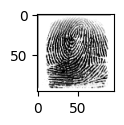

INFO:root:Fingerprint = 275__F_Left_index_finger.BMP, Prediction = [5.426538336905651e-06]


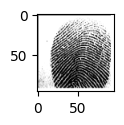

INFO:root:Fingerprint = 232__M_Right_index_finger.BMP, Prediction = [0.9999960064888]


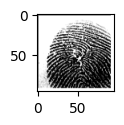

INFO:root:Fingerprint = 504__M_Right_index_finger.BMP, Prediction = [1.0]


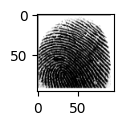

In [17]:
if __name__ == "__main__":

  logging.basicConfig(level=logging.INFO)

  #
  # Get the model server info.
  #
  host = "https://fingerprint-bkoz.apps.hou.edgelab.online"
  url = f'{host}/v2'
  r = ""
  try:
    r = requests.get(url)
    # logging.info("")
    # logging.info(f'Triton Server Status:')
    # logging.info("")
    # logging.info(f'{r.content.decode()}')
    # logging.info("")
  except:
    logging.error(f"Requests Error! {r}")

  #
  # Make 4 single image predictions.
  #
  img_size = 96
  filepath = '../data/fingerprint_real'
  filenames = [
    '103__F_Left_index_finger.BMP',
    '275__F_Left_index_finger.BMP',
    '232__M_Right_index_finger.BMP',
    '504__M_Right_index_finger.BMP'
    ]
  import skimage
  for filename in filenames:
        
    #
    # Read in an image file using skimage.
    #
    f = f'{filepath}/{filename}'
    F_Left_index = skimage.io.imread(f, as_gray=True)
    img_resized = skimage.transform.resize(F_Left_index, (96, 96))
    
    logging.debug(f'img_resized.shape = {img_resized.shape}')
    
    #
    # Make an inference via REST.
    #
    try:
      r = make_prediction(img_resized, img_size, host)
      logging.debug(f'REST inference response = {r}')
      p = ast.literal_eval(r.content.decode())
      logging.info(f"Fingerprint = {filename}, Prediction = {p['outputs'][0]['data']}")
      f = plt.figure()
      f.set_figwidth(1)
      f.set_figheight(1)  
      imgplot = plt.imshow(img_resized, cmap="gray") 
      plt.show()
    except:
      logging.error(f"Requests POST Error {r.content}")
